<a href="https://colab.research.google.com/github/naamsanam/StableDiffusion/blob/main/script/dreambooth/DreamBooth_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 15109 MiB


https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth

## Install Requirements

In [2]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate==0.12.0 transformers ftfy bitsandbytes gradio

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 27.3 MB/s 
     |████████████████████████████████| 18.7 MB 149 kB/s 
     |████████████████████████████████| 143 kB 38.3 MB/s 
     |████████████████████████████████| 5.3 MB 54.5 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 62.5 MB 1.2 MB/s 
     |████████████████████████████████| 5.3 MB 60.1 MB/s 
     |████████████████████████████████| 7.6 MB 59.9 MB/s 
     |████████████████████████████████| 2.3 MB 60.7 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 270 kB 68.5 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |██████████

In [3]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


### Install xformers from precompiled wheel.

In [4]:
%pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various_6/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl
# These were compiled on Tesla T4, should also work on P100, thanks to https://github.com/metrolobo

# If precompiled wheels don't work, install it with the following command. It will take around 40 minutes to compile.
# %pip install git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers

     |████████████████████████████████| 102.9 MB 1.0 MB/s 


## Settings and run

In [5]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = False #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Name/Path of the initial model.
MODEL_NAME = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#@markdown Path for images of the concept for training.
INSTANCE_DIR = "/content/data/skss" #@param {type:"string"}
!mkdir -p $INSTANCE_DIR

#@markdown A general name for class like dog for dog images.
CLASS_NAME = "cartoon" #@param {type:"string"}
CLASS_DIR = f"/content/data/{CLASS_NAME}"

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/skss" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

#@markdown sks is a rare identifier, feel free to replace it.
print(f"[*] Regularization images will be saved to {CLASS_DIR}")

[*] Weights will be saved at /content/stable_diffusion_weights/skss
[*] Regularization images will be saved to /content/data/cartoon


In [6]:
#@markdown Upload your images by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to INSTANCE_DIR (it uploads faster)

import os
from google.colab import files
import shutil

uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

Saving c6.jpg to c6.jpg


# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [7]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="skss" \
  --class_prompt="cartoon" \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=100


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--num_cpu_threads_per_process` was set to `1` to improve out-of-box performance
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Downloading: 100% 543/543 [00:00<00:00, 549kB/s]
Fetching 16 files:   0% 0/16 [00:00<?, ?it/s]
Downloading: 100% 342/342 [00:00<00:00, 324kB/s]
Fetching 16 files:   6% 1/16 [00:02<00:39,  2.62s/it]
Downloading: 100% 4.56k/4.56k [00:00<00:00, 3.94MB/s]
Fetching 16 files:  19% 3/16 [00:05<00:21,  1.64s/it]
Downloading:   0% 0.00/1.22G [00:00<?, ?B/s]
Downloading:   1% 7.86M/1.22G [00:00<00:15, 78.6MB/s]
Downloading:   1% 16.2M/1.22G [00:00<00:14, 81.3MB/s]
Downloading:   2% 24.3M/1.22G [00:00<00:14, 79.6MB/s]
Downloading:   3% 32.6M/1.22G [00:00<00:14, 80.8MB/s]
Downloading:   3%

## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [8]:
#@markdown Download script
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py

In [9]:
#@markdown Run conversion.
ckpt_path = OUTPUT_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB), might loose some quality.
fp16 = False #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /content/stable_diffusion_weights/skss/model.ckpt


## Inference

In [10]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = OUTPUT_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, torch_dtype=torch.float16).to("cuda")

g_cuda = None

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [11]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/50 [00:00<?, ?it/s]

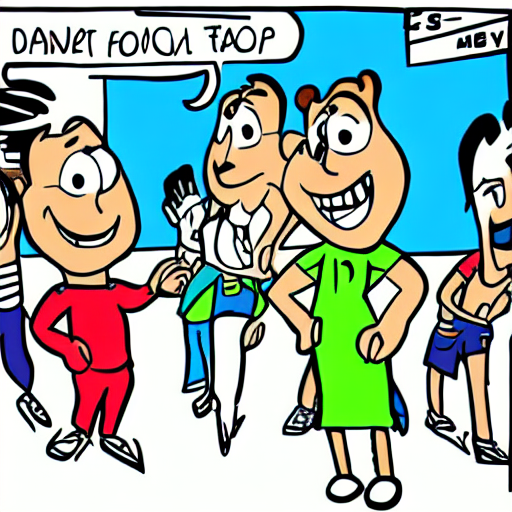

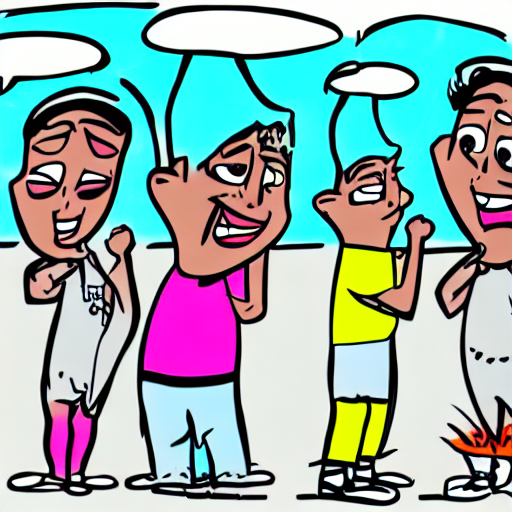

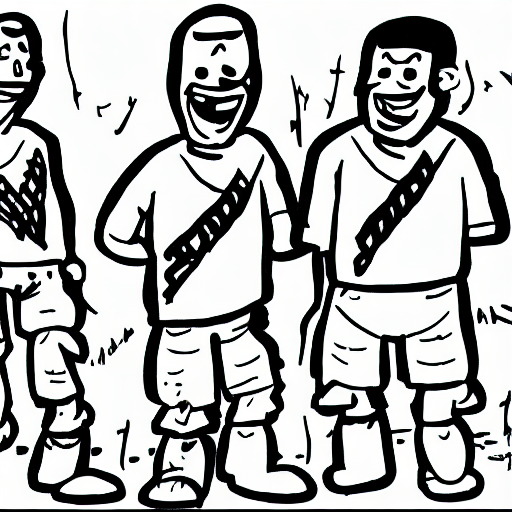

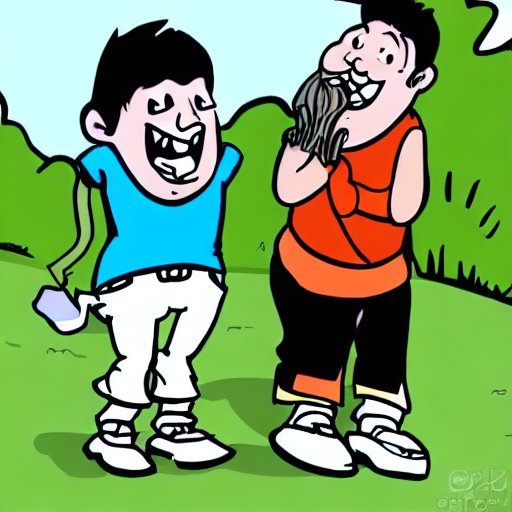

In [12]:
#@title Run for generating images.

prompt = "full body picture of skss cartoon while laughing" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [ ]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of sks dog in a bucket")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

In [ ]:
#@title (Optional) Delete diffuser weights and only keep the ckpt to free up drive space (4GB).

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
for f in glob(OUTPUT_DIR+"/*"):
    if not f.endswith(".ckpt"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)

In [13]:
# make sure cloned code is saved in content
%cd /content

# verify CUDA
!/usr/local/cuda/bin/nvcc --version

# clone modified version of U-2-Net
!git clone https://github.com/shreyas-bk/U-2-Net

# make images directory (to store imput images) and results (to store output images) in U-2-Net folder
%cd /content/U-2-Net
print('making images directory')
!mkdir images
print('making results directory')
!mkdir results
print('making cropped results directory')
!mkdir cropped_results

#import required modules
print('importing...')
from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2
print('Done!')

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Cloning into 'U-2-Net'...
remote: Enumerating objects: 520, done.
remote: Total 520 (delta 0), reused 0 (delta 0), pack-reused 520
Receiving objects: 100% (520/520), 12.39 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/U-2-Net
making images directory
making results directory
making cropped results directory
importing...
Done!


In [14]:
# change to images directory to upload image files
%cd /content/U-2-Net/images
uploaded = files.upload()


/content/U-2-Net/images


Saving script2.jpg to script2.jpg


In [15]:
# change back to U-2-Net directory
%cd /content/U-2-Net

/content/U-2-Net


In [16]:
# run the test script, and outputs are saved to results folder
!python -W ignore u2net_test.py

['/content/U-2-Net/images/script2.jpg']
inferencing: script2.jpg


In [17]:
import numpy as np
from glob import glob
# get the names of the images that were uploaded, removing .png
image_dir = os.path.join(os.getcwd(), 'results/*.png')
print(image_dir)
file_names = glob(image_dir)
#print(file_names)
names = [os.path.basename(name[:-4]) for name in file_names]
names

/content/U-2-Net/results/*.png


['script2']

In [18]:
def process_image_named(name, threshold_cutoff = 0.90, use_transparency = False):
  result_img = load_img('/content/U-2-Net/results/'+name+'.png')
  # convert result-image to numpy array and rescale(255 for RBG images)
  RESCALE = 255
  out_img = img_to_array(result_img)
  out_img /= RESCALE
  # define the cutoff threshold below which, background will be removed.
  THRESHOLD = threshold_cutoff

  # refine the output
  out_img[out_img > THRESHOLD] = 1
  out_img[out_img <= THRESHOLD] = 0

  if use_transparency:
    # convert the rbg image to an rgba image and set the zero values to transparent
    shape = out_img.shape
    a_layer_init = np.ones(shape = (shape[0],shape[1],1))
    mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
    a_layer = mul_layer*a_layer_init
    rgba_out = np.append(out_img,a_layer,axis=2)
    mask_img = Img.fromarray((rgba_out*RESCALE).astype('uint8'), 'RGBA')
  else:
    mask_img = Img.fromarray((out_img*RESCALE).astype('uint8'), 'RGB')

  # load and convert input to numpy array and rescale(255 for RBG images)
  input = load_img('/content/U-2-Net/images/'+name+'.jpg')
  inp_img = img_to_array(input)
  inp_img /= RESCALE

 
  if use_transparency:
    # since the output image is rgba, convert this also to rgba, but with no transparency
    a_layer = np.ones(shape = (shape[0],shape[1],1))
    rgba_inp = np.append(inp_img,a_layer,axis=2)

    #simply multiply the 2 rgba images to remove the backgound
    rem_back = (rgba_inp*rgba_out)
    rem_back_scaled = Img.fromarray((rem_back*RESCALE).astype('uint8'), 'RGBA')
  else:
    rem_back = (inp_img*out_img)
    rem_back_scaled = Img.fromarray((rem_back*RESCALE).astype('uint8'), 'RGB')

  # select a layer(can be 0,1 or 2) for bounding box creation and salient map
  LAYER = 2
  out_layer = out_img[:,:,LAYER]

  # find the list of points where saliency starts and ends for both axes
  x_starts = [np.where(out_layer[i]==1)[0][0] if len(np.where(out_layer[i]==1)[0])!=0 else out_layer.shape[0]+1 for i in range(out_layer.shape[0])]
  x_ends = [np.where(out_layer[i]==1)[0][-1] if len(np.where(out_layer[i]==1)[0])!=0 else 0 for i in range(out_layer.shape[0])]
  y_starts = [np.where(out_layer.T[i]==1)[0][0] if len(np.where(out_layer.T[i]==1)[0])!=0 else out_layer.T.shape[0]+1 for i in range(out_layer.T.shape[0])]
  y_ends = [np.where(out_layer.T[i]==1)[0][-1] if len(np.where(out_layer.T[i]==1)[0])!=0 else 0 for i in range(out_layer.T.shape[0])]
  
  # get the starting and ending coordinated for the box
  startx = min(x_starts)
  endx = max(x_ends)
  starty = min(y_starts)
  endy = max(y_ends)
  
  # show the resulting coordinates
  start = (startx,starty)
  end = (endx,endy)
  start,end

  cropped_rem_back_scaled = rem_back_scaled.crop((startx,starty,endx,endy))
  if use_transparency:
    cropped_rem_back_scaled.save('/content/U-2-Net/cropped_results/'+name+'_cropped_no-bg.png')
  else:
    cropped_rem_back_scaled.save('/content/U-2-Net/cropped_results/'+name+'_cropped_no-bg.jpg')
  
  cropped_mask_img = mask_img.crop((startx,starty,endx,endy))

  if use_transparency:
    cropped_mask_img.save('/content/U-2-Net/cropped_results/'+name+'_cropped_no-bg_mask.png')
  else:
    cropped_mask_img.save('/content/U-2-Net/cropped_results/'+name+'_cropped_no-bg_mask.jpg')

In [19]:
#Remove BG, Crop and save each image pair
for name in names:
  process_image_named(name)               #jpg, no alpha
  #process_image_named(name, 0.9, True)   #png, with transparency

In [20]:
%cd /content/U-2-Net/cropped_results/
!zip /content/cropped_results.zip ./*

/content/U-2-Net/cropped_results
  adding: script2_cropped_no-bg.jpg (deflated 3%)
  adding: script2_cropped_no-bg_mask.jpg (deflated 13%)


In [21]:
# download the result
# takes a while for the progress indicator to appear
files.download('/content/cropped_results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>